Author: Adam Moss

Data from

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
import datetime
import time
import matplotlib.dates as mdates
import os
import sys

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,path)

In [4]:
from covid.utils import get_ons_deaths, get_region_data, get_covid_activity

In [5]:
def gaussian_smooth(data, days=0):
    if days > 0:
        return gaussian_filter1d(data, days)
    else:
        return data

In [6]:
population = pd.read_csv('../data/all_cause_mortality/population.csv')

In [7]:
population

,year,population
0,2020,68065223
1,2019,67530172
2,2018,67141684
3,2017,66727461
4,2016,66297944
5,2015,65860146
6,2014,65423047
7,2013,64984018
8,2012,64525312
9,2011,64021919


In [8]:
dfs = []
for year in range(2012, 2021):
    df = get_ons_deaths(year)
    df['year'] = year
    df['totalDeathsCorrected'] = df['totalDeaths'] * population[population['year'] == 2020]['population'].values[0] / population[population['year'] == year]['population'].values[0]
    dfs.append(df)
df = pd.concat(dfs)

In [9]:
df

,week,date,areaName,totalDeaths,year,totalDeathsCorrected
0,1,2012-01-06,Total,10514,2012,11090.806576
1,2,2012-01-13,Total,11343,2012,11965.286189
2,3,2012-01-20,Total,10393,2012,10963.168417
3,4,2012-01-27,Total,10320,2012,10886.163578
4,5,2012-02-03,Total,10117,2012,10672.026833
...,...,...,...,...,...,...
578,49,2020-12-04,Wales,836,2020,836.000000
579,50,2020-12-11,Wales,814,2020,814.000000
580,51,2020-12-18,Wales,882,2020,882.000000
581,52,2020-12-25,Wales,825,2020,825.000000


In [10]:
df[df['week'] == 53]

,week,date,areaName,totalDeaths,year,totalDeathsCorrected
52,53,2016-01-01,Total,7524,2015,7775.912581
105,53,2016-01-01,North East,407,2015,420.626850
158,53,2016-01-01,North West,1074,2015,1109.958813
211,53,2016-01-01,Yorkshire and The Humber,755,2015,780.278309
264,53,2016-01-01,East Midlands,646,2015,667.628858
317,53,2016-01-01,West Midlands,799,2015,825.751482
370,53,2016-01-01,East,653,2015,674.863226
423,53,2016-01-01,London,766,2015,791.646602
476,53,2016-01-01,South East,1123,2015,1160.599392
529,53,2016-01-01,South West,757,2015,782.345272


In [11]:
def week_to_date(week, year):
    return df[(df['year'] == year) & (df['week'] == week)].iloc[0]['date']

In [12]:
metrics = [
    "newCasesByPublishDate",
    "newCasesBySpecimenDate",
    "uniquePeopleTestedBySpecimenDateRollingSum",
    "uniqueCasePositivityBySpecimenDateRollingSum",
    "newDeathsByDeathDate",
    "newDeaths28DaysByPublishDate",
    "newDeaths28DaysByDeathDate",
    "newOnsDeathsByRegistrationDate",
    "newDeaths60DaysByPublishDate",
    "newDeaths60DaysByDeathDate",
]

In [13]:
nhs_metrics = [
    "newAdmissions",
    "covidOccupiedMVBeds",
    "hospitalCases"
]

In [14]:
dashboard = get_region_data(metrics=metrics, nhs_metrics=nhs_metrics)

In [15]:
covid_activity = get_covid_activity()

In [16]:
def get_excess_deaths(min_week, max_week, region):
    if max_week >= min_week:
        df_region = df[(df['year'] >= 2010) & (df['year'] <= 2019) & (df['areaName'].str.contains(region)) & (df['week'] >= min_week) & (df['week'] <= max_week)]
    else:
        df_region = df[(df['year'] >= 2010) & (df['year'] <= 2019) & (df['areaName'].str.contains(region)) & ((df['week'] <= max_week) | (df['week'] >= min_week))]
    agg = df_region.groupby('year').agg({'totalDeathsCorrected': [np.sum]})
    mean_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    std_deaths = np.std(agg['totalDeathsCorrected']['sum'])
    if max_week >= min_week:
        df_region = df[(df['year'] == 2020) & (df['areaName'].str.contains(region)) & ( df['week'] >= min_week) & (df['week'] <= max_week)]
    else:
        df_region = df[(df['areaName'].str.contains(region)) & (((df['year'] == 2021) & (df['week'] <= max_week)) | ((df['year'] == 2020) & (df['week'] >= min_week)))]    
    agg = df_region.agg({'totalDeathsCorrected': [np.sum]})
    current_deaths = np.mean(agg['totalDeathsCorrected']['sum'])
    print(current_deaths)
    excess_deaths = current_deaths - mean_deaths 
    z_score = excess_deaths / std_deaths
    p_value = norm.sf(abs(z_score))*2
    return int(excess_deaths), z_score, p_value

In [17]:
get_excess_deaths(10, 25, 'Total')

220270.0


(56119, 12.274347832185812, 1.2439006532162507e-34)

In [18]:
def get_excess_deaths(min_week, max_week, region, min_historical_year=2010, max_historical_year=2019, feedback=0, metric='totalDeathsCorrected'):
    df_region = df[df['areaName'].str.contains(region)].copy()
    same_year = max_week >= min_week
    for i, year in enumerate(range(min_historical_year, max_historical_year + 1)):
        if same_year:
            df_region.loc[((df_region['year'] == year) & (df_region['week'] >= min_week) & (df_region['week'] <= max_week)), 'period'] = i + 1
        else:
            df_region.loc[((df_region['year'] == year) & (df_region['week'] >= min_week) & (df_region['week'] <= 52)), 'period'] = i + 1
            df_region.loc[((df_region['year'] == year + 1) & (df_region['week'] >= 1) & (df_region['week'] <= max_week)), 'period'] = i + 1
    df_region.dropna(inplace=True)
    if feedback > 1:
        print(df_region)
    agg = df_region.groupby('period').agg({metric: [np.sum]})
    mean_deaths = np.mean(agg[metric]['sum'])
    std_deaths = np.std(agg[metric]['sum'])
    if feedback > 0:
        print(agg)
        print(mean_deaths, std_deaths)
    df_region = df[df['areaName'].str.contains(region)].copy()
    if same_year:
        df_region = df_region[((df_region['year'] == 2020) & (df_region['week'] >= min_week) & (df_region['week'] <= max_week))]
    else:
        df_region = df_region[(((df_region['year'] == 2020) & (df_region['week'] >= min_week)) | ((df_region['year'] == 2021) & (df_region['week'] <= max_week)))]
    agg = df_region.agg({metric: [np.sum]})
    current_deaths = np.mean(agg[metric]['sum'])
    excess_deaths = current_deaths - mean_deaths 
    z_score = excess_deaths / std_deaths
    p_value = norm.sf(abs(z_score))*2
    return int(excess_deaths), z_score, p_value

In [19]:
get_excess_deaths(52, 52, 'London', min_historical_year=2015, max_historical_year=2019, 
                  feedback=2, metric='totalDeaths')

     week       date areaName  totalDeaths  year  totalDeathsCorrected  period
422    52 2015-12-25   London          870  2015            899.128648     1.0
415    52 2016-12-30   London          761  2016            781.285687     2.0
415    52 2017-12-29   London          814  2017            830.319192     3.0
415    52 2018-12-28   London          655  2018            664.009575     4.0
415    52 2019-12-27   London          653  2019            658.173810     5.0
       totalDeaths
               sum
period            
1.0            870
2.0            761
3.0            814
4.0            655
5.0            653
750.6 86.08042750823209


(339, 3.9428242845046544, 8.052765625605641e-05)

In [20]:
get_excess_deaths(52, 52, 'London', min_historical_year=2010, max_historical_year=2019, 
                  feedback=2, metric='totalDeaths')

     week       date areaName  totalDeaths  year  totalDeathsCorrected  period
415    52 2012-12-28   London          792  2012            835.449763     3.0
415    52 2013-12-27   London          590  2013            617.974739     4.0
415    52 2014-12-26   London          773  2014            804.218388     5.0
422    52 2015-12-25   London          870  2015            899.128648     6.0
415    52 2016-12-30   London          761  2016            781.285687     7.0
415    52 2017-12-29   London          814  2017            830.319192     8.0
415    52 2018-12-28   London          655  2018            664.009575     9.0
415    52 2019-12-27   London          653  2019            658.173810    10.0
       totalDeaths
               sum
period            
3.0            792
4.0            590
5.0            773
6.0            870
7.0            761
8.0            814
9.0            655
10.0           653
738.5 89.36302367310542


(351, 3.933394211075548, 8.375470927803025e-05)

In [21]:
def make_plot(region, plot_excess_deaths=False):
    df_region = df[(df['year'] <= 2019) & (df['week'] <= 52) & (df['areaName'].str.contains(region))].groupby(['date', 'week', 'year']).sum().reset_index()
    agg = df_region.groupby(['week']).agg({'totalDeathsCorrected': [np.mean, np.std]}).reset_index()
    p1 = agg['totalDeathsCorrected']['mean'] + agg['totalDeathsCorrected']['std']
    p2 = agg['totalDeathsCorrected']['mean'] + 2* agg['totalDeathsCorrected']['std']
    n1 = agg['totalDeathsCorrected']['mean'] - agg['totalDeathsCorrected']['std']
    n2 = agg['totalDeathsCorrected']['mean'] - 2 * agg['totalDeathsCorrected']['std']
    p1 = p1.append(pd.Series(p1.iloc[-1]))
    p2 = p2.append(pd.Series(p2.iloc[-1]))
    n1 = n1.append(pd.Series(n1.iloc[-1]))
    n2 = n2.append(pd.Series(n2.iloc[-1]))
    plt.figure(figsize=(12,8))
    df_region = df[(df['year'] == 2020) & (df['areaName'].str.contains(region))].groupby(['date', 'week', 'year']).sum().reset_index().replace({0:np.nan})
    plt.plot(df_region['date'], df_region['totalDeaths'], color='red', linewidth=2, label='2020')
    if plot_excess_deaths:
        plt.plot(df_region['date'], df_region['totalDeaths'] - agg['totalDeathsCorrected']['mean'], color='grey', linewidth=2, label='2020 excess deaths')
    plt.fill_between(df_region['date'].append(df_region['date'] + datetime.timedelta(days=365+7)), n2.append(n2), p2.append(p2), color='#8CD3F5', label='2010-2019 (2 SD)')
    plt.fill_between(df_region['date'].append(df_region['date'] + datetime.timedelta(days=365+7)), n1.append(n1), p1.append(p1), color='#006FED', label='2010-2019 (1 SD)')
    max_deaths = np.max(df_region['totalDeaths'])
    df_region = covid_activity[(covid_activity['areaName'].str.contains(region))].groupby(['date']).sum().reset_index().replace({0:np.nan})
    plt.plot(df_region['date'], gaussian_smooth(df_region['covidOccupiedMVBeds'], 0), color='green', linewidth=2, label='COVID occupied ICU')
    df_region = dashboard[(dashboard['areaName'].str.contains(region))].groupby(['date']).sum().reset_index().replace({0:np.nan})
    plt.plot(df_region['date'], gaussian_smooth(df_region['covidOccupiedMVBeds'], 0), color='green', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Deaths')
    plt.suptitle('Population adjusted UK weekly deaths (' + region + ')')
    plt.title('https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales', fontsize=8)
    plt.axvline(datetime.datetime(2020, 3, 23), label='Lockdown', color='orange', linewidth=3, alpha=0.5)
    plt.axvline(datetime.datetime(2020, 11, 5), color='orange', linewidth=3, alpha=0.5)
    plt.axvline(datetime.datetime(2021, 1, 5), color='orange', linewidth=3, alpha=0.5)
    excess_deaths, z_score, p_value = get_excess_deaths(10, 25, region)
    plt.text(week_to_date(14, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(14, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(14, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(25, 40, region)
    plt.text(week_to_date(28, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(28, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(28, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    excess_deaths, z_score, p_value = get_excess_deaths(40, 53, region)
    plt.text(week_to_date(43, 2020), max_deaths * 1.4, 'Excess deaths: %s' % excess_deaths, rotation=0)
    plt.text(week_to_date(43, 2020), max_deaths * 1.3, 'Z score: %.3e' % z_score, rotation=0)
    plt.text(week_to_date(43, 2020), max_deaths * 1.2, 'P value: %.3e' % p_value, rotation=0)
    plt.axvline(week_to_date(10, 2020), linestyle='--')
    plt.axvline(week_to_date(25, 2020), linestyle='--')
    plt.axvline(week_to_date(40, 2020), linestyle='--')
    plt.axvline(week_to_date(53, 2020), linestyle='--')
    ax = plt.gca()
    ax.set_ylim(top=max_deaths * 1.5)
    ax.set_xlim([datetime.datetime(2020, 1, 1), datetime.datetime.now()+datetime.timedelta(days=10)])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.legend(loc='upper left')
    plt.gcf().autofmt_xdate() # Rotation
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig('plots/all_cause_mortality/' + region.replace(' ','') + '.png', transparent=False, facecolor='white')

In [22]:
regions = df['areaName'].unique().tolist() + ['North', 'Midlands', 'South']

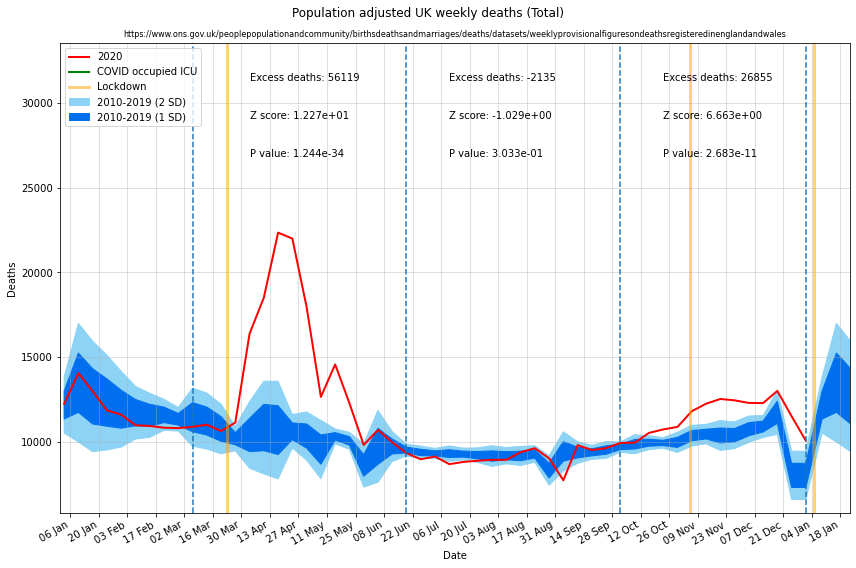

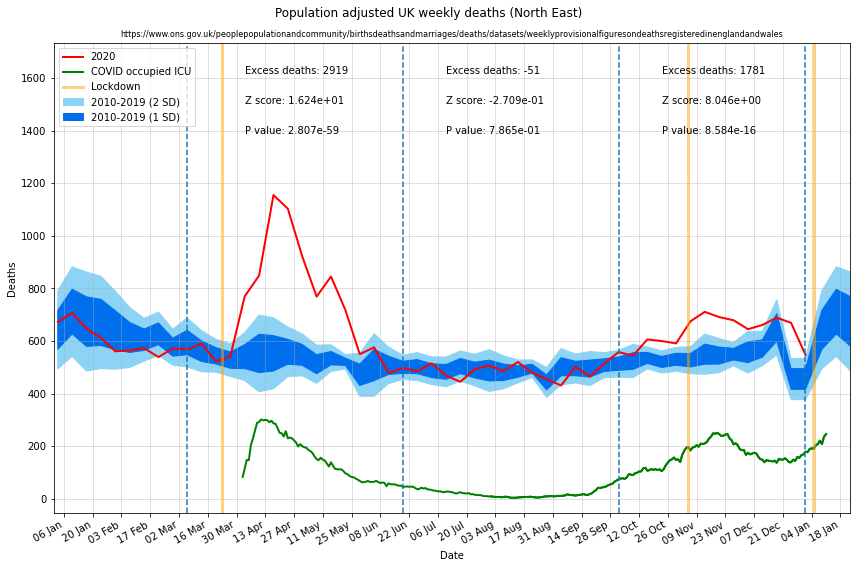

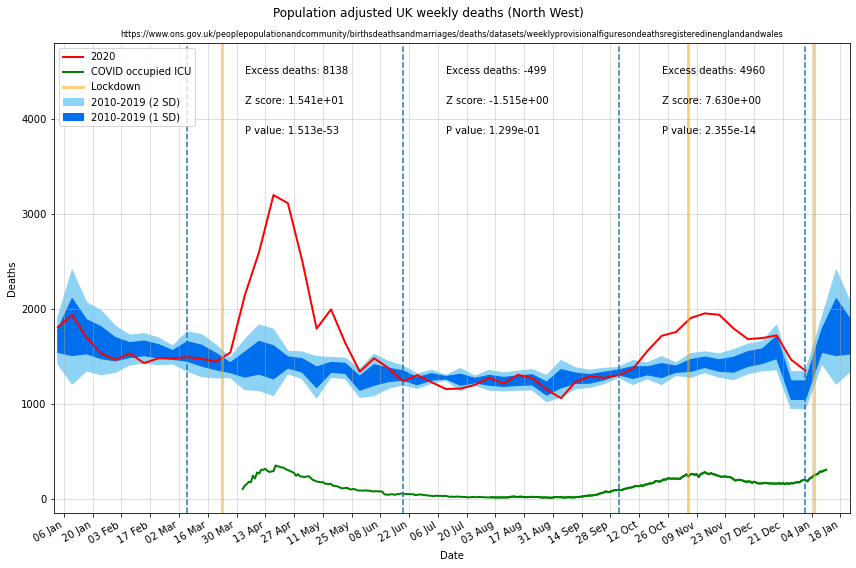

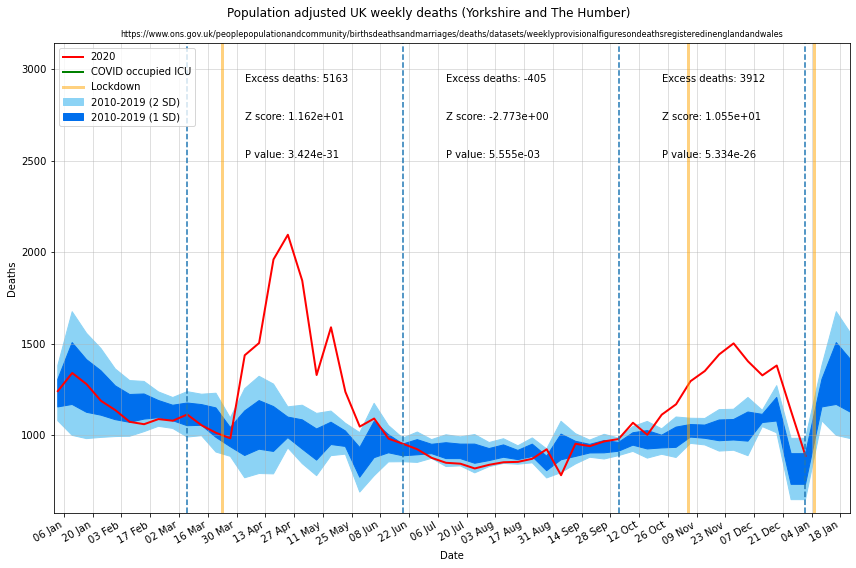

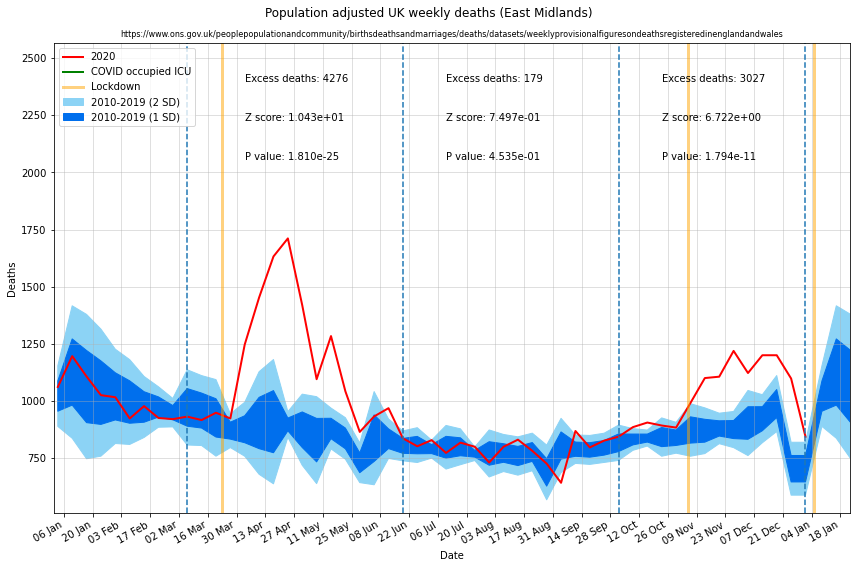

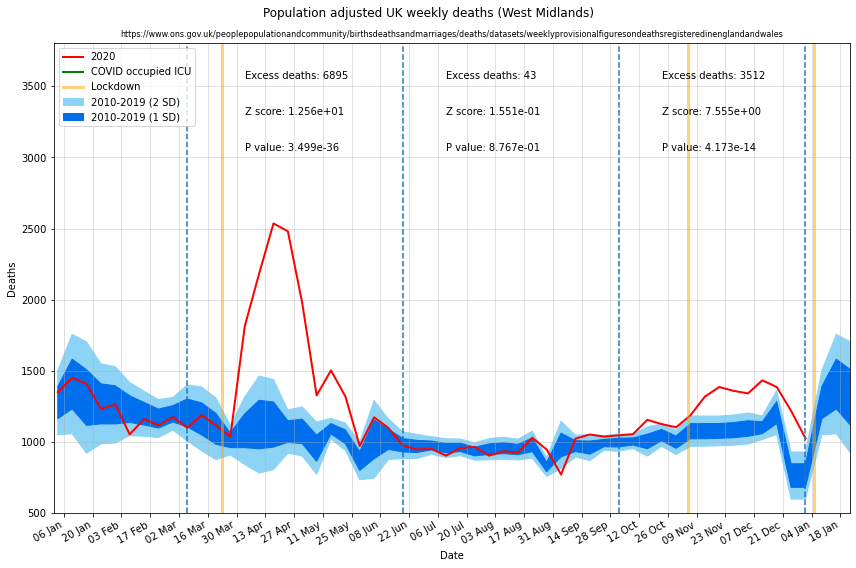

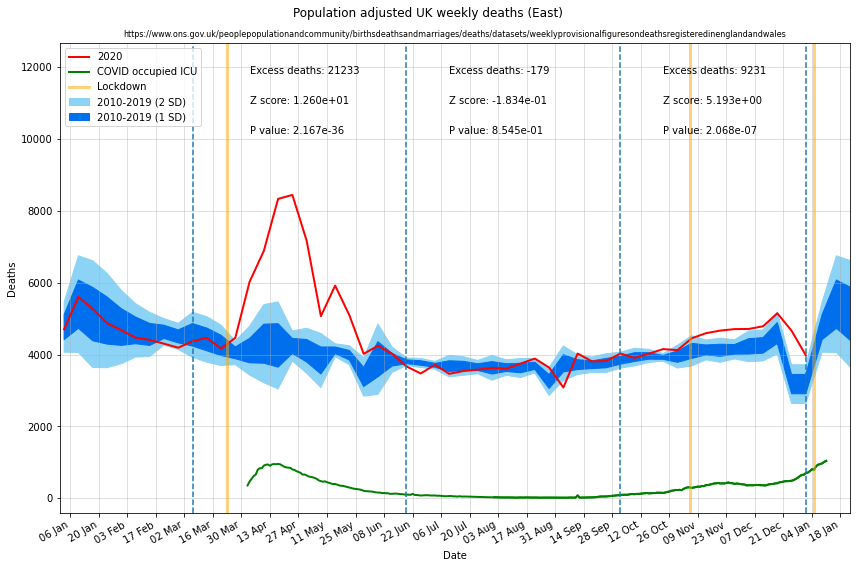

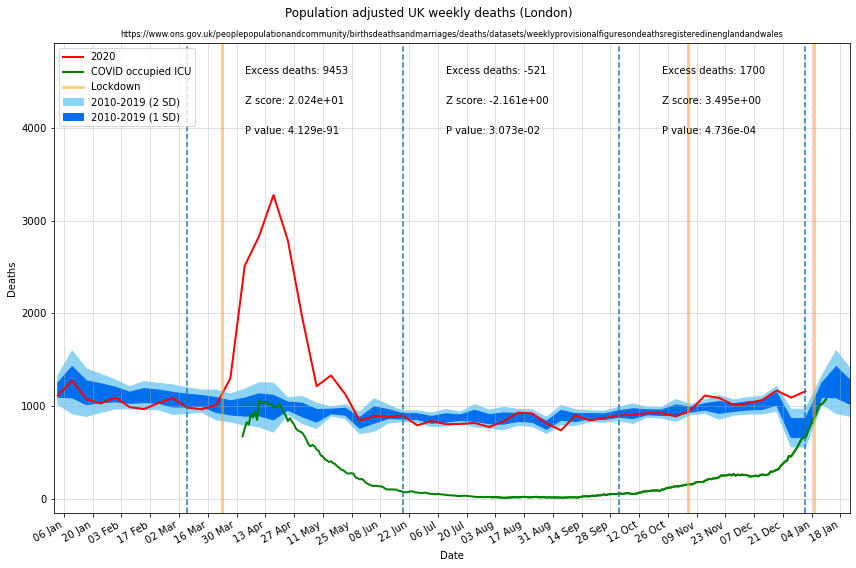

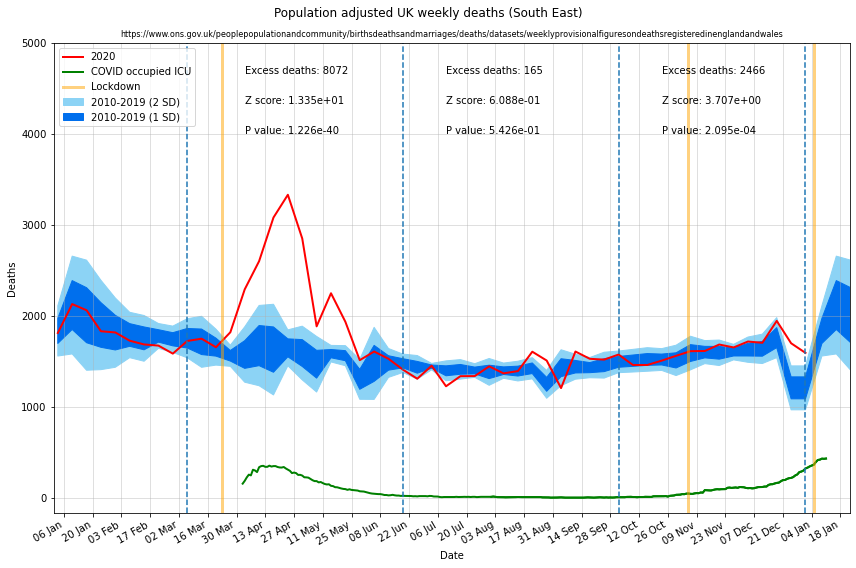

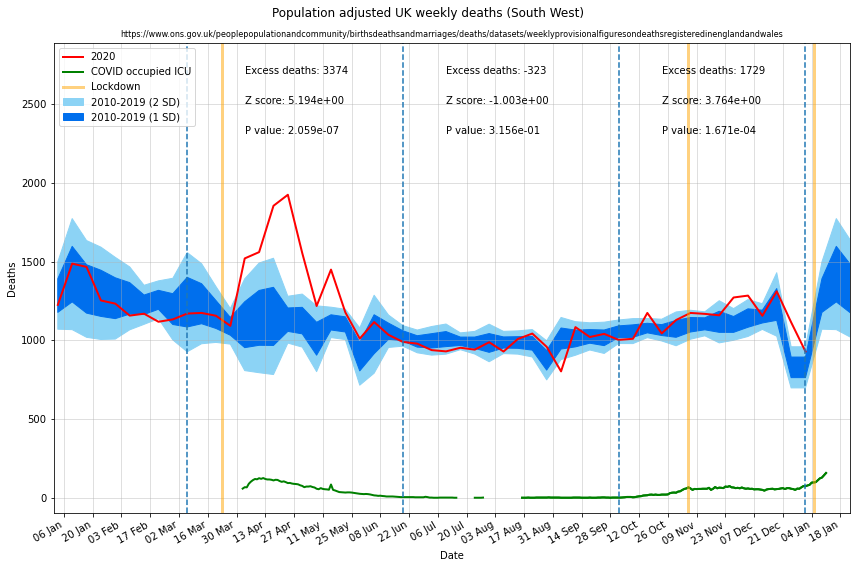

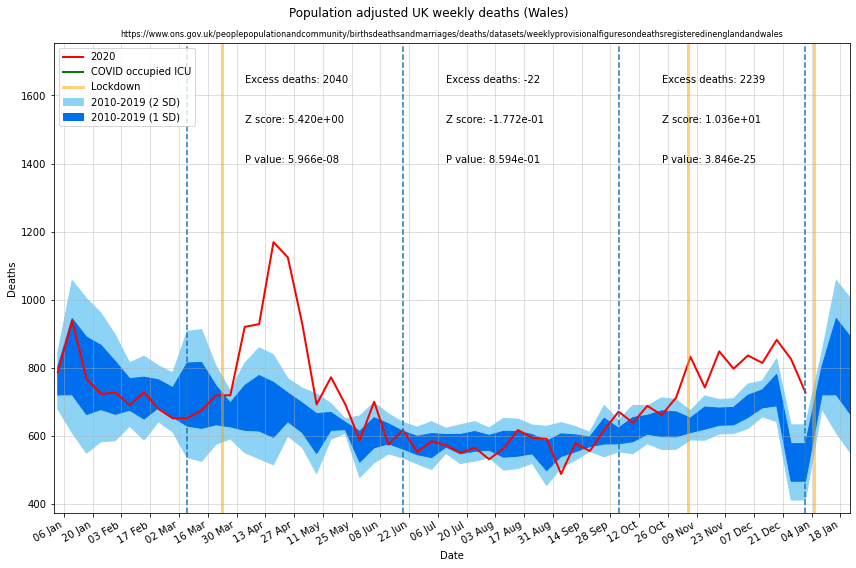

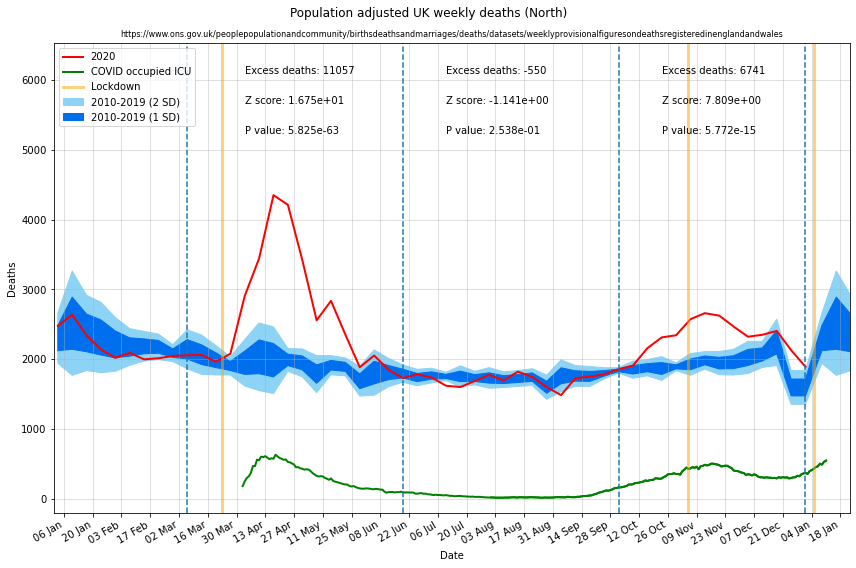

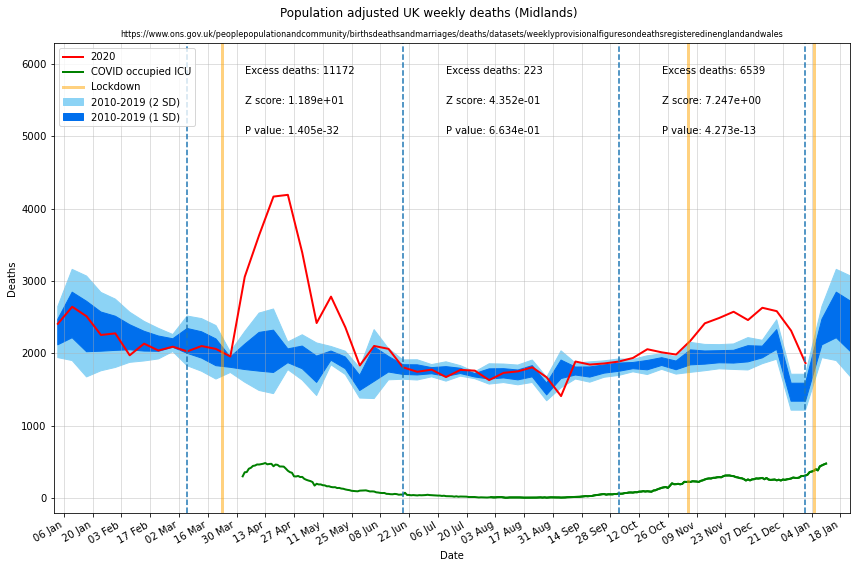

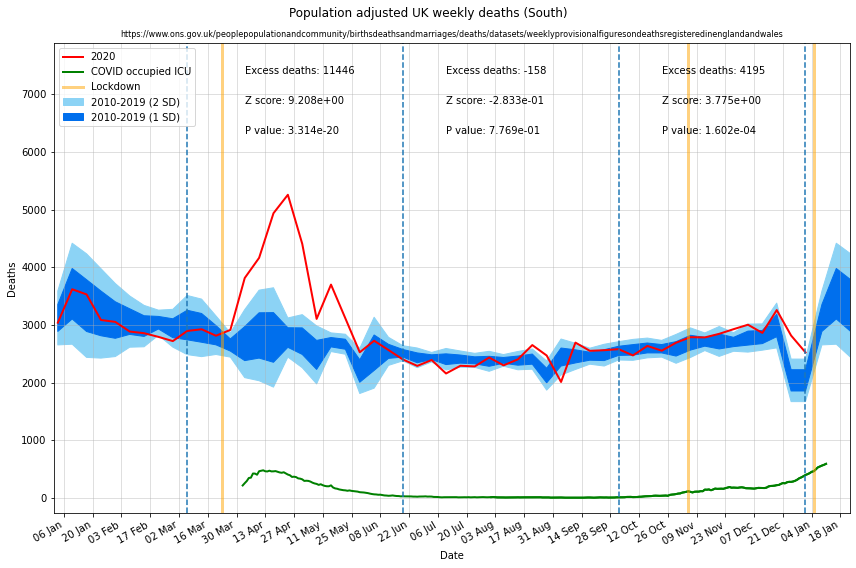

In [23]:
for region in regions:
    make_plot(region)